In [2]:
import os
import scipy.io 
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import LeaveOneOut, KFold
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm 

# Load data
fiftyWordData = scipy.io.loadmat('../tuningTasks/t12.2022.05.03_fiftyWordSet.mat')

In [3]:
# mean-subtract within block
def meanSubtract(dat, brainArea='6v'):
    if brainArea=='6v':
        dat['feat'] = np.concatenate([dat['tx2'][:,0:128].astype(np.float32), dat['spikePow'][:,0:128].astype(np.float32)], axis=1)
        # dat['feat'] = dat['tx2'][:,0:128].astype(np.float32)
    elif brainArea=='44':
        dat['feat'] = np.concatenate([dat['tx2'][:,128:].astype(np.float32), dat['spikePow'][:,128:].astype(np.float32)], axis=1)

    blockList = np.squeeze(np.unique(dat['blockNum']))
    for b in blockList:
        loopIdx = np.squeeze(dat['blockNum']==b)
        dat['feat'][loopIdx,:] -= np.mean(dat['feat'][loopIdx,:],axis=0,keepdims=True)
    return dat

# mean subtraction (de-mean)
fiftyWordData_6v = meanSubtract(fiftyWordData)

# Sample piece: [sequence_length, channel_index]
# NOTE: dat['feat'] are the continuous features
print(f"Feature length: {len(fiftyWordData_6v['feat'])}")

Feature length: 228605


In [4]:
feats = fiftyWordData_6v['feat'][:, 0:128]
cueList = fiftyWordData_6v['cueList']
trialCues = fiftyWordData_6v['trialCues']
goTrialEpochs = fiftyWordData_6v['goTrialEpochs']

In [5]:
feats.shape, goTrialEpochs

((228605, 128),
 array([[   132,    231],
        [   341,    440],
        [   570,    669],
        ...,
        [228042, 228141],
        [228275, 228374],
        [228505, 228605]]))

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter1d

# Example variables (replace with actual data)
# tx: (228605, 256) -> Continuous recording data
# goTrialEpochs: (1020, 2) -> Start and end indices of each trial
# trialCues: (1020, 1) -> Labels for each trial

max_length = max(end - start for start, end in goTrialEpochs)

# Extract trial data based on goTrialEpochs
trial_data = [feats[start:end] for start, end in goTrialEpochs]
# Convert list to NumPy array (padding might be needed if trial lengths vary)
padded_trials = np.array([np.pad(trial, ((0, max_length - len(trial)), (0, 0))) for trial in trial_data])

# Example sigma for Gaussian smoothing (adjust as needed)
sigma = 4  
# Extract and smooth trials
trial_data = [gaussian_filter1d(feats[start:end], sigma=sigma, axis=0) for start, end in goTrialEpochs]
padded_trials_gs = np.array([np.pad(trial, ((0, max_length - len(trial)), (0, 0))) for trial in trial_data])
window_start, window_end = 0, 101
padded_trials_gs = padded_trials_gs[:, window_start:window_end]

# Flatten labels for compatibility
labels = trialCues.flatten()

# CrossEntropyLoss requires labels starting from 0
labels = labels - 1

X_train, X_test, y_train, y_test = train_test_split(padded_trials_gs, labels, test_size=0.2)
X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, test_size=0.5)

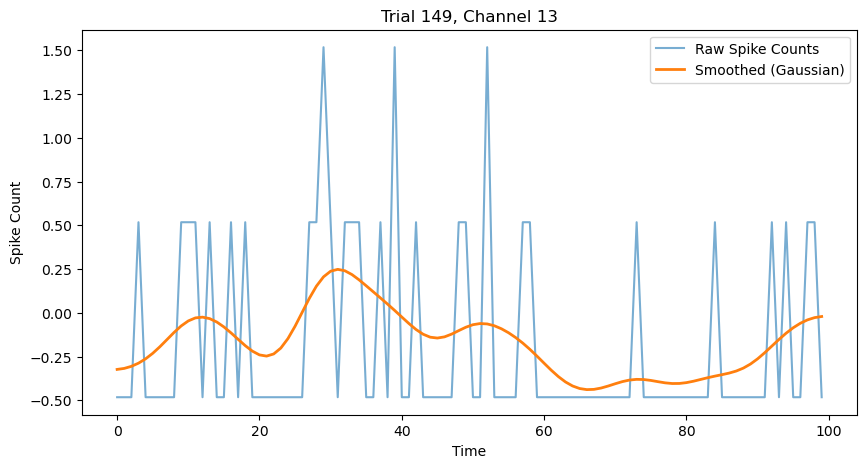

In [60]:
import matplotlib.pyplot as plt

# Select a random trial index
sample_idx = np.random.randint(len(trial_data))

# Get raw and smoothed data
start, end = goTrialEpochs[sample_idx]
raw_trial = tx[start:end]
smoothed_trial = gaussian_filter1d(raw_trial, sigma=sigma, axis=0)

# Select a single channel to visualize
channel = np.random.randint(tx.shape[1])

# Plot
plt.figure(figsize=(10, 5))
plt.plot(raw_trial[:, channel], label="Raw Spike Counts", alpha=0.6)
plt.plot(smoothed_trial[:, channel], label="Smoothed (Gaussian)", linewidth=2)
plt.xlabel("Time")
plt.ylabel("Spike Count")
plt.title(f"Trial {sample_idx}, Channel {channel}")
plt.legend()
plt.show()


In [11]:
class GRUClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=2):
        super(GRUClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,
                          batch_first=True, dropout=0.1)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        batch_size = x.shape[0]  # Ensure we track the batch size
        _, h_n = self.gru(x)  # h_n shape: (num_layers, batch_size, hidden_size)
        out = self.fc(h_n[-1])  # Take the last layer's hidden state
        
        assert out.shape[0] == batch_size, f"Output batch size {out.shape[0]} doesn't match input batch size {batch_size}"
        return out


    def train_model(self, dataloader, optimizer, criterion, num_epochs=10):
        self.train()
        for epoch in tqdm(range(num_epochs)):
            for inputs, labels in dataloader:
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

     
def kfold_gru(trials, labels, hidden_size=128, num_epochs=200, lr=0.001, num_folds=5):
    # device = 'cpu'  
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_size = trials.shape[2]  # num_channels
    num_classes = len(np.unique(labels))
    # Initialize KFold
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=30)
    
    accuracies = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(trials)):
        print(f"Training on fold {fold + 1}")
        
        # Split data into training and validation sets
        train_X, val_X = trials[train_idx], trials[val_idx]
        train_y, val_y = labels[train_idx], labels[val_idx]
        
        # Convert data to PyTorch tensors
        train_X = torch.tensor(train_X).to(device)
        train_y = torch.tensor(train_y, dtype=torch.long).to(device)
        val_X = torch.tensor(val_X).to(device)
        val_y = torch.tensor(val_y, dtype=torch.long).to(device)
        
        # Create DataLoader for training data
        train_dataset = TensorDataset(train_X, train_y)
        train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        
        # Initialize model, optimizer, and loss function
        model = GRUClassifier(input_size, hidden_size, num_classes).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        
        # Train the model
        model.train_model(train_dataloader, optimizer, criterion, num_epochs)
        
        # Evaluate on validation data
        model.eval()
        with torch.no_grad():
            pred_y = model(val_X).argmax(dim=1)
            fold_accuracy = (pred_y == val_y).float().mean().item()  # Compute accuracy
            accuracies.append(fold_accuracy)
        
        print(f"Fold {fold + 1} accuracy: {fold_accuracy:.4f}")
    
    # Compute mean accuracy across all folds
    mean_acc = np.mean(accuracies)
    print(f"Mean accuracy across {num_folds} folds: {mean_acc:.4f}")
    return mean_acc

# Example usage
# mean_acc = kfold_gru(trials_np, labels)
mean_acc = kfold_gru(padded_trials_gs, labels)
print(f"Final Mean Accuracy: {mean_acc:.4f}")


Training on fold 1


100%|██████████| 200/200 [00:56<00:00,  3.51it/s]


Fold 1 accuracy: 0.6127
Training on fold 2


100%|██████████| 200/200 [00:48<00:00,  4.11it/s]


Fold 2 accuracy: 0.6324
Training on fold 3


100%|██████████| 200/200 [00:50<00:00,  3.95it/s]


Fold 3 accuracy: 0.6912
Training on fold 4


100%|██████████| 200/200 [00:48<00:00,  4.17it/s]


Fold 4 accuracy: 0.6176
Training on fold 5


100%|██████████| 200/200 [00:47<00:00,  4.22it/s]

Fold 5 accuracy: 0.6373
Mean accuracy across 5 folds: 0.6382
Final Mean Accuracy: 0.6382


In [12]:
import numpy as np
import torch
from pykalman import KalmanFilter
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def extract_kalman_features(sequences):
    """
    Apply Kalman Filtering to extract hidden state representations for each sequence.
    """
    n_samples, seq_len, n_channels = sequences.shape
    kalman = KalmanFilter(
        transition_matrices=np.eye(n_channels),  # Identity transition matrix
        observation_matrices=np.eye(n_channels),  # Direct observation
        transition_covariance=0.01 * np.eye(n_channels),  # Small process noise
        observation_covariance=0.1 * np.eye(n_channels)  # Measurement noise
    )
    
    features = []
    
    for seq in tqdm(sequences):
        smoothed_state_means, _ = kalman.smooth(seq)  # Apply Kalman smoothing
        features.append(smoothed_state_means[-1])  # Use last hidden state as feature
    
    return np.array(features)

def kalman_naive_bayes_classification(trials, labels, num_folds=5):
    """
    Perform k-fold cross-validation using Kalman filter features and a Naïve Bayes classifier.
    """
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    accuracies = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(trials)):
        print(f"Fold {fold + 1}/{num_folds}")
        
        # Split data
        train_X, val_X = trials[train_idx], trials[val_idx]
        train_y, val_y = labels[train_idx], labels[val_idx]

        # Apply Kalman filtering to extract features
        train_features = extract_kalman_features(train_X)
        val_features = extract_kalman_features(val_X)

        # Train Naïve Bayes classifier
        model = GaussianNB()
        model.fit(train_features, train_y)

        # Predict and evaluate
        pred_y = model.predict(val_features)
        fold_accuracy = accuracy_score(val_y, pred_y)
        accuracies.append(fold_accuracy)
        
        print(f"Fold {fold + 1} Accuracy: {fold_accuracy:.4f}")
    
    mean_acc = np.mean(accuracies)
    print(f"Mean Accuracy across {num_folds} folds: {mean_acc:.4f}")
    return mean_acc

# Example usage
mean_accuracy = kalman_naive_bayes_classification(padded_trials_gs, labels)
print(f"Final Mean Accuracy: {mean_accuracy:.4f}")


Fold 1/5


100%|██████████| 204/204 [01:19<00:00,  2.58it/s]


Fold 1 Accuracy: 0.0931
Fold 2/5


100%|██████████| 204/204 [01:16<00:00,  2.67it/s]


Fold 2 Accuracy: 0.1275
Fold 3/5


100%|██████████| 204/204 [01:12<00:00,  2.83it/s]


Fold 3 Accuracy: 0.0686
Fold 4/5


100%|██████████| 204/204 [01:13<00:00,  2.78it/s]


Fold 4 Accuracy: 0.1127
Fold 5/5


100%|██████████| 204/204 [01:16<00:00,  2.66it/s]

Fold 5 Accuracy: 0.1127
Mean Accuracy across 5 folds: 0.1029
Final Mean Accuracy: 0.1029


In [ ]:
from analysis import triggeredAvg
fAvg_fiftyWord, fCI_fiftyWord, trials_fiftywords = triggeredAvg(fiftyWordData['feat'].astype(np.float32),
                                                                fiftyWordData['goTrialEpochs'][:, 0],
                                                                np.squeeze(fiftyWordData['trialCues']), [-50, 50], smoothSD=4)

fiftyWordCuesToUse = np.arange(0,50).astype(np.int32)
trials_np = np.array(trials_fiftywords).reshape(-1, 100, 256)
# Assuming trials_fiftyWord_subset has shape (2000, 100, 256) and labels has shape (2000,)
labels = torch.arange(0, 51).repeat_interleave(20).numpy()
print(f"#included trials:\t{trials_np.shape}")
print(f"#labels:\t\t{labels.shape}")
 

In [40]:
# SVM
def leave_one_out_svm(trials, labels):
    """
    Perform Leave-One-Out Cross-Validation with SVM on the trials dataset.
    
    Parameters:
    - trials: NumPy array of shape (num_trials, time_steps, num_channels)
    - labels: NumPy array of shape (num_trials,) with corresponding labels
    
    Returns:
    - Mean accuracy across all LOO iterations
    """
    num_trials = trials.shape[0]
    accuracies = []

    for i in range(num_trials):
        # Split into train and test sets
        test_X = trials[i]  # Shape: (100, 256)
        test_y = labels[i]
        
        train_X = np.delete(trials, i, axis=0)  # Remove i-th trial
        train_y = np.delete(labels, i, axis=0)

        # Compute mean and std from the training set
        mean = np.mean(train_X, axis=(0,1))  # Mean over trials and time steps
        std = np.std(train_X, axis=(0,1))    # Std over trials and time steps

        # Z-score normalization
        train_X = (train_X - mean) / std
        test_X = (test_X - mean) / std  # Normalize test using training mean & std

        # Take mean over time dimension (100 time steps → 256 channels)
        train_X = np.mean(train_X, axis=1)  # Shape: (num_trials-1, 256)
        test_X = np.mean(test_X, axis=0).reshape(1, -1)  # Shape: (1, 256)

        # Train SVM classifier
        svm = SVC(kernel='linear', C=1.0)  # You can adjust the kernel and C parameter
        svm.fit(train_X, train_y)

        # Test the model
        pred_y = svm.predict(test_X)
        accuracy = accuracy_score([test_y], pred_y)
        accuracies.append(accuracy)

    # Compute final mean accuracy
    mean_accuracy = np.mean(accuracies)
    return mean_accuracy


def kfold_svm(trials, labels, num_folds=5):
    """
    Perform k-fold Cross-Validation with SVM on the trials dataset.
    
    Parameters:
    - trials: NumPy array of shape (num_trials, time_steps, num_channels)
    - labels: NumPy array of shape (num_trials,) with corresponding labels
    - num_folds: Number of folds for cross-validation
    
    Returns:
    - Mean accuracy across all k-fold iterations
    """
    num_trials = trials.shape[0]
    accuracies = []

    # Initialize KFold
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    for fold, (train_idx, val_idx) in enumerate(kf.split(trials)):
        print(f"Training on fold {fold + 1}")

        # Split into train and validation sets
        train_X, val_X = trials[train_idx], trials[val_idx]
        train_y, val_y = labels[train_idx], labels[val_idx]

        # Compute mean and std from the training set
        mean = np.mean(train_X, axis=(0,1))  # Mean over trials and time steps
        std = np.std(train_X, axis=(0,1))    # Std over trials and time steps

        # Z-score normalization
        train_X = (train_X - mean) / std
        val_X = (val_X - mean) / std  # Normalize validation using training mean & std

        # Take mean over time dimension (100 time steps → 256 channels)
        train_X = np.mean(train_X, axis=1)  # Shape: (num_train_trials, 256)
        val_X = np.mean(val_X, axis=1)      # Shape: (num_val_trials, 256)

        # Train SVM classifier
        svm = SVC(kernel='linear', C=1.0)  # You can adjust the kernel and C parameter
        svm.fit(train_X, train_y)

        # Test the model
        pred_y = svm.predict(val_X)
        accuracy = accuracy_score(val_y, pred_y)
        accuracies.append(accuracy)

    # Compute final mean accuracy
    mean_accuracy = np.mean(accuracies)
    print(f"Mean accuracy across {num_folds} folds: {mean_accuracy:.4f}")
    return mean_accuracy

# Example usage
# mean_acc = leave_one_out_svm(trials_np, labels)
mean_acc = kfold_svm(trials=trials_np, labels=labels)
print(f"Final Mean Accuracy: {mean_acc:.4f}")


Training on fold 1
Training on fold 2
Training on fold 3
Training on fold 4
Training on fold 5
Mean accuracy across 5 folds: 0.9529
Final Mean Accuracy: 0.9529


gaussian naive bayes

In [31]:
from analysis import gnb_loo
y_pred, unroll_y = gnb_loo(trials_fiftyWord_subset, [0,100], np.arange(0,256).astype(np.int32))
print(np.mean(y_pred==unroll_y))

0.87


svm

In [41]:
from sklearn.svm import SVC
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

def svm_loo(trials_input, timeWindow, chanIdx, C=1.0):
    unroll_Feat = []
    for t in range(len(trials_input)):
        for x in range(trials_input[t].shape[0]):
            unroll_Feat.append(trials_input[t][x,:,:])

    # Concatenate all the trials of all labels and calculate mean and variance
    unroll_Feat = np.concatenate(unroll_Feat, axis=0)
    mn = np.mean(unroll_Feat, axis=0)
    sd = np.std(unroll_Feat, axis=0)
    
    unroll_X = []
    unroll_y = []

    # Normalize each trial
    for t in range(len(trials_input)):
        for x in range(trials_input[t].shape[0]):
            tmp = (trials_input[t][x,:,:] - mn[np.newaxis,:]) / sd[np.newaxis,:]
            b1 = np.mean(tmp[timeWindow[0]:timeWindow[1], chanIdx], axis=0)
            
            unroll_X.append(np.concatenate([b1]))
            unroll_y.append(t)

    unroll_X = np.stack(unroll_X, axis=0)
    unroll_y = np.array(unroll_y).astype(np.int32)

    y_pred = np.zeros(unroll_X.shape[0])

    # Leave-one out 
    for t in range(unroll_X.shape[0]):
        X_train = np.concatenate([unroll_X[:t, :], unroll_X[t+1:, :]], axis=0)
        y_train = np.concatenate([unroll_y[:t], unroll_y[t+1:]])

        svm = SVC(kernel='linear', C=C)  # Using linear SVM
        svm.fit(X_train, y_train)

        y_pred[t] = svm.predict(unroll_X[np.newaxis, t, :])
        # y_pred[t] = svm.predict(unroll_X[np.newaxis, t, :])[0]


    return y_pred, unroll_y

y_pred, unroll_y = svm_loo(trials_fiftyWord_subset, [50,100], np.arange(0,256).astype(np.int32))
print(np.mean(y_pred==unroll_y))

0.98
